Problem 2:  Implement t-SNE dim reduction, run on MNIST dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

In [2]:
# Load and preprocess MNIST
mnist = fetch_openml('mnist_784', version=1)
X_mnist, y_mnist = mnist.data[:5000], mnist.target[:5000].astype(int) #the sampling number affects the values of the KL (loss) function
X_mnist = X_mnist / 255.0  # Normalize to 0-1 range


In [3]:
# Reduce dimensionality with PCA to 50 dimensions
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_mnist)

In [4]:
# Compute pairwise distance matrix D
#o measure how similar or different each point is in high-dimensional space.
# t-SNE uses these distances to create the probability distribution P_ij, which guides how points are arranged in the low-dimensional space.
D = squareform(pdist(X_pca, 'euclidean'))  # Euclidean distance between points

The P function computes the probability matrix P by adjusting a Gaussian kernel to match a target entropy based on perplexity. It uses binary search to tune beta, ensuring P reflects local similarities. The result is a symmetric, normalized probability distribution

In [5]:
# function to compute probability matrix P using perplexity
def compute_P(D, perplexity=30):
    """compute probability matrix P with binary search for beta to match target perplexity"""

    target_entropy = np.log2(perplexity)  # convert perplexity into an entropy value
    N = D.shape[0]  # get the number of data points
    P = np.zeros((N, N))  # initialize P matrix with zeros
    beta = np.ones(N) * 1.0  # initialize beta values (1/variance of Gaussian)

    for i in range(N):
        betamin, betamax = -np.inf, np.inf  # define min and max bounds for beta
        trials, Hdiff = 0, 1  # set trial counter and entropy difference
        while abs(Hdiff) > 1e-5 and trials < 50:  # binary search loop
            P_i = np.exp(-D[i] * beta[i])  # compute probability distribution for point i
            P_i[i] = 0  # remove self-similarity by setting diagonal to zero
            P_i /= np.sum(P_i)  # normalize P_i to sum to 1
            H = -np.sum(P_i * np.log2(P_i + 1e-10))  # compute Shannon entropy of P_i
            Hdiff = H - target_entropy  # compute difference between actual and target entropy

            # adjust beta using binary search to ensure P matches the target entropy (set by perplexity)
            if Hdiff > 0:  #if beta too small, Pr are apred out, increase beta
                betamin = beta[i] # increase lower bound of beta
                beta[i] = beta[i] * 2 if betamax == np.inf else (beta[i] + betamax) / 2 # increase beta to spread probabilities more
            else: #beta too large, Pr are sharper, decrese beta
                betamax = beta[i]  # decrease upper bound of beta
                beta[i] = beta[i] / 2 if betamin == -np.inf else (beta[i] + betamin) / 2 # decrease beta to make probabilities sharper
            trials += 1  # increment trial count to limit search iterations

        P[i] = P_i  # store computed probabilities for row i

    P = (P + P.T) / 2  # make P symmetric
    P /= np.sum(P)  # normalize P to ensure it is a valid probability distribution
    return P  # return computed probability matrix


In [6]:
# compute probability matrix P with adjustable perplexity
P = compute_P(D, perplexity=30)  # Perplexity : numbers of neighboords that are considered when computing similarities or distances btw points . lower > local structure. higher > global relationships and struc

t-SNE optimization to project high-dimensional data into 2D. It initializes random positions, computes pairwise similarities using a Student-t distribution, and iteratively updates positions using gradient descent with momentum and adaptive learning rates to improve the embedding.

Iteration 20: KL-Divergence = 4.9640


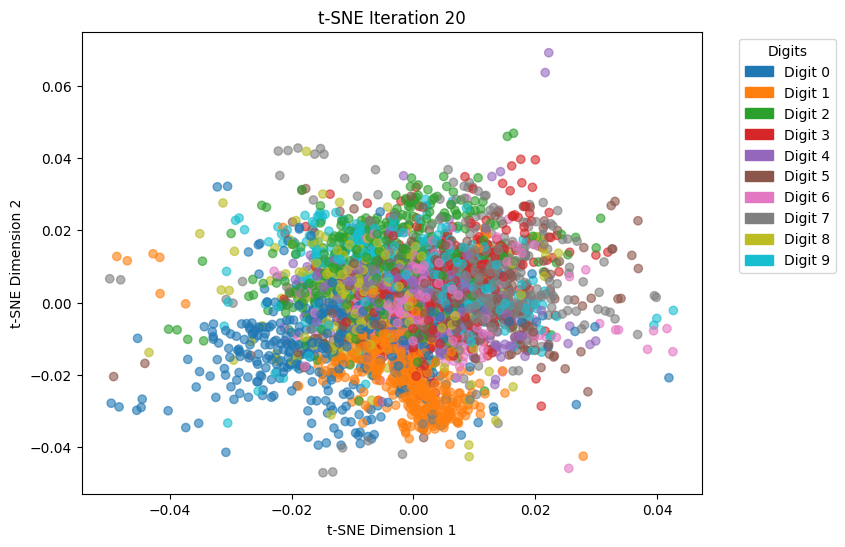

Iteration 40: KL-Divergence = 3.5664


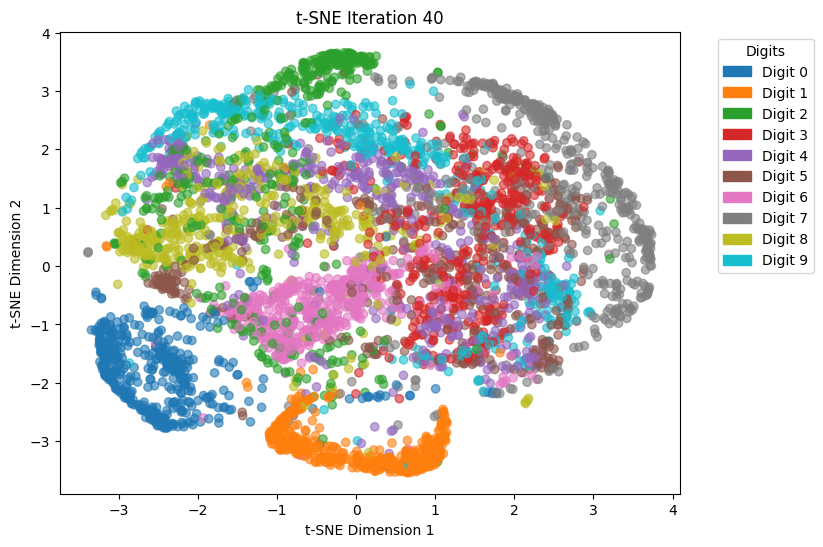

Iteration 60: KL-Divergence = 2.9479


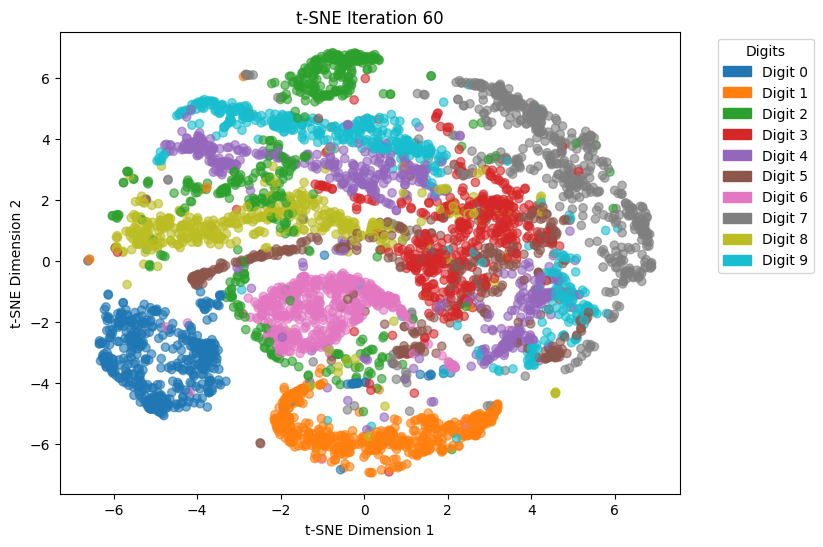

Iteration 80: KL-Divergence = 2.6547


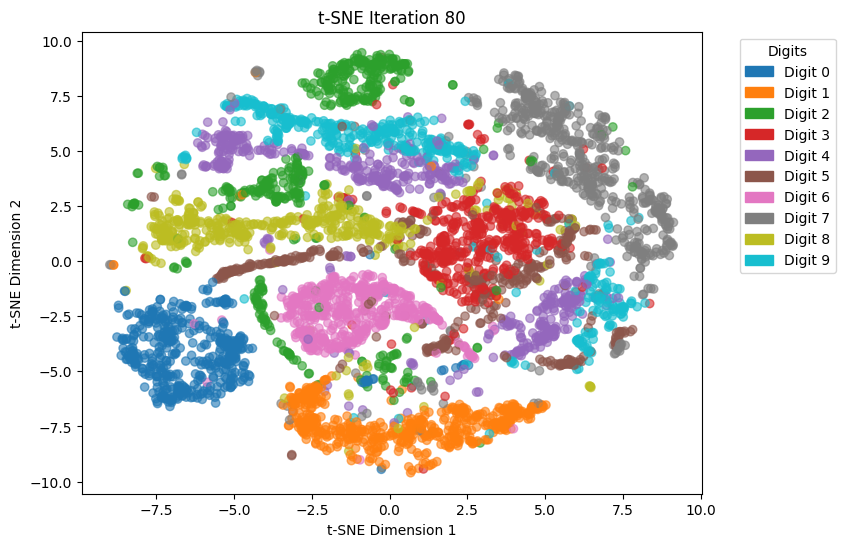

Iteration 100: KL-Divergence = 2.4771


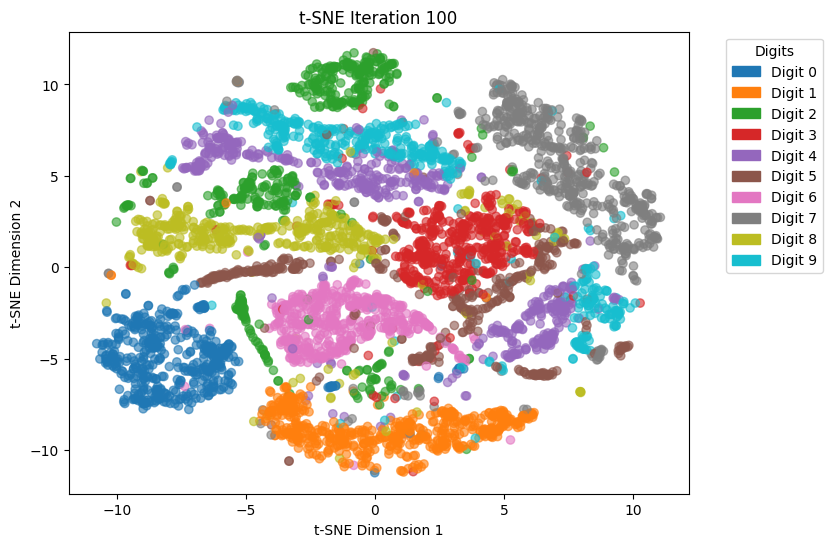

Iteration 120: KL-Divergence = 2.3524


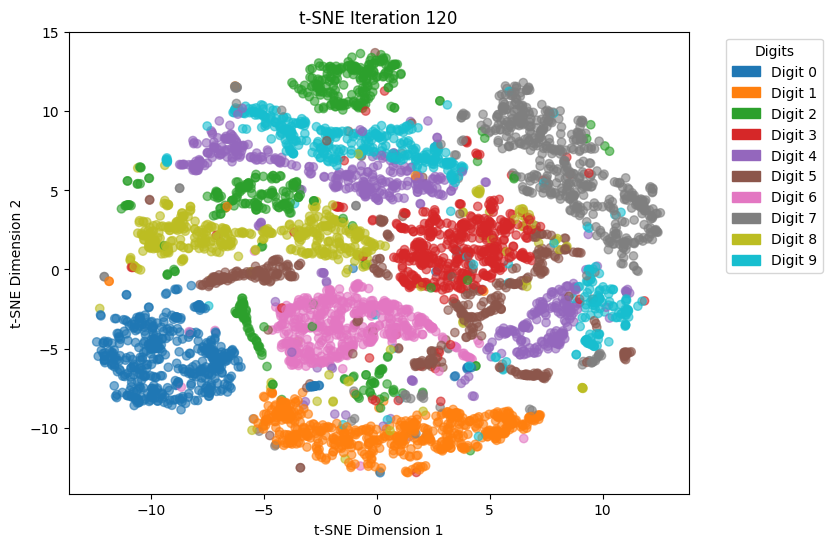

Iteration 140: KL-Divergence = 2.2571


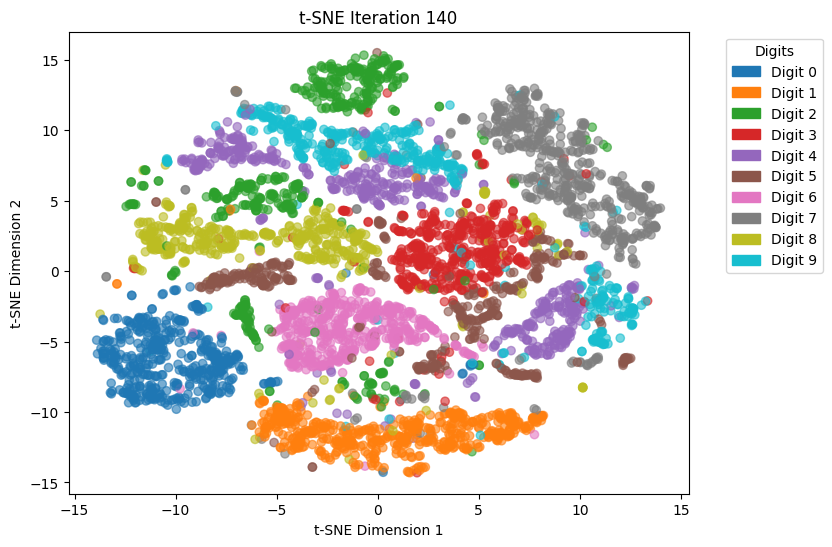

Iteration 160: KL-Divergence = 2.1810


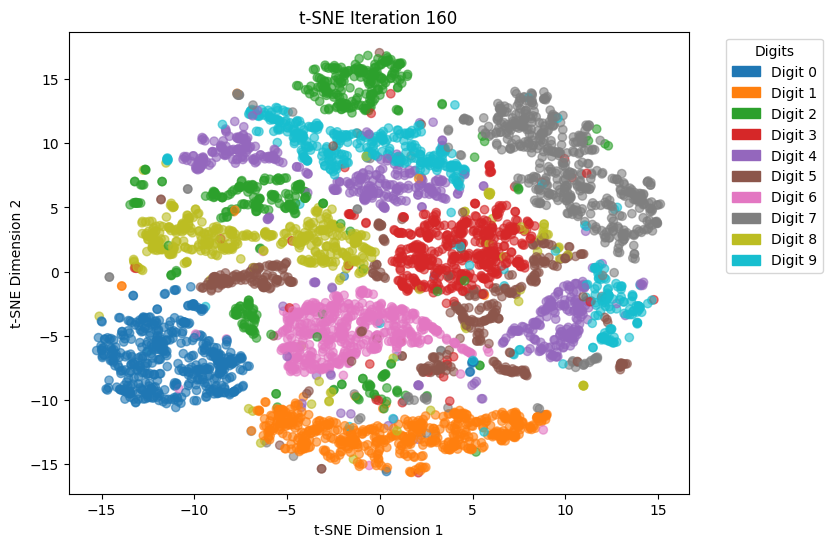

Iteration 180: KL-Divergence = 2.1191


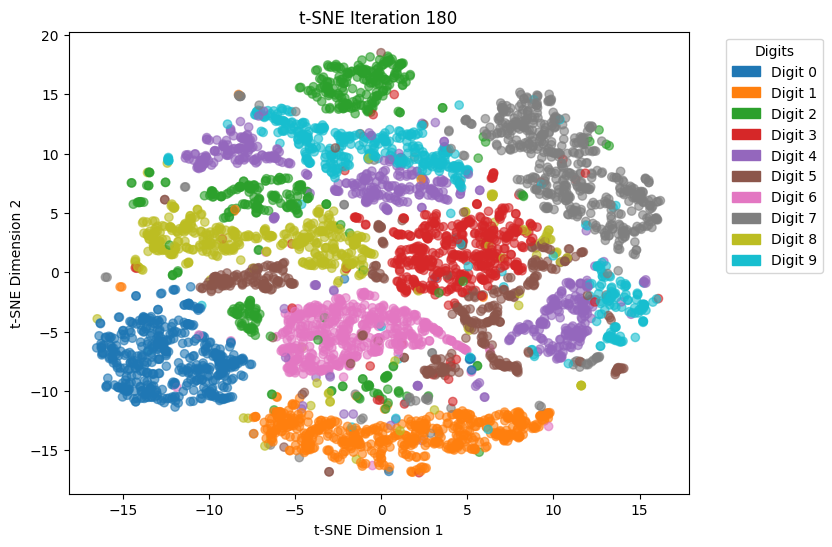

Iteration 200: KL-Divergence = 2.0672


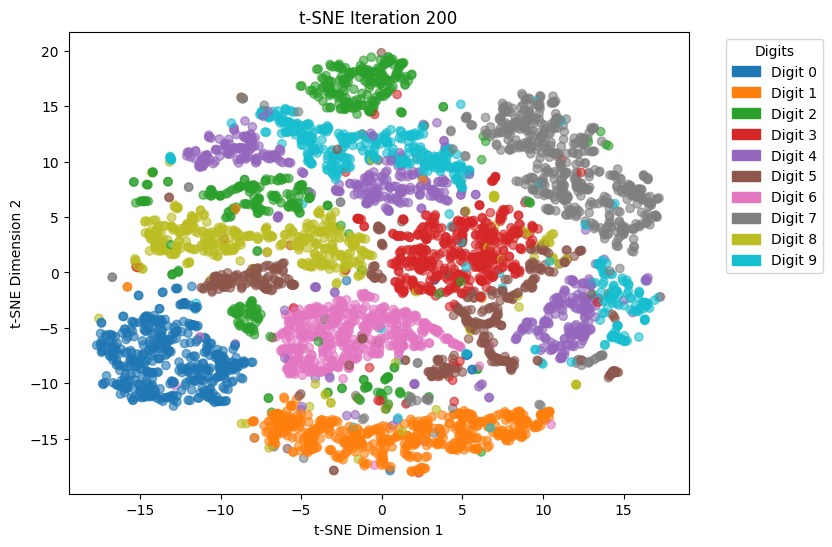

Iteration 220: KL-Divergence = 2.0226


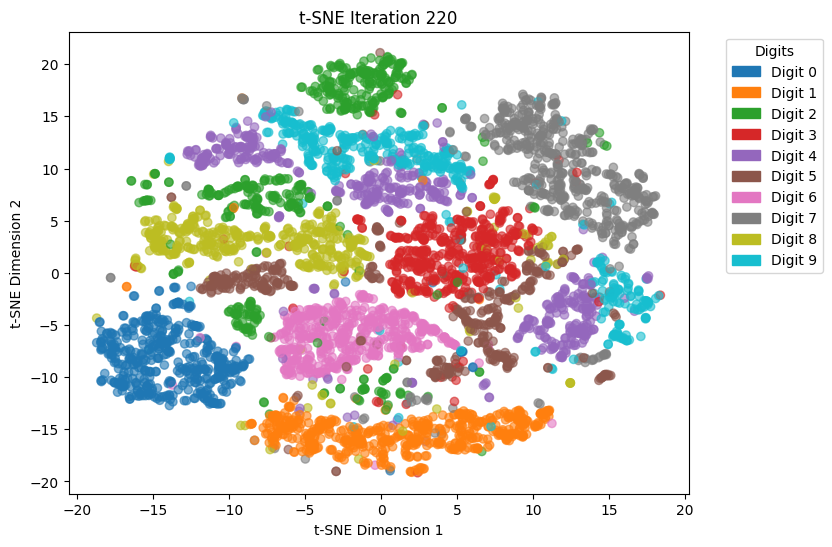

Iteration 240: KL-Divergence = 1.9836


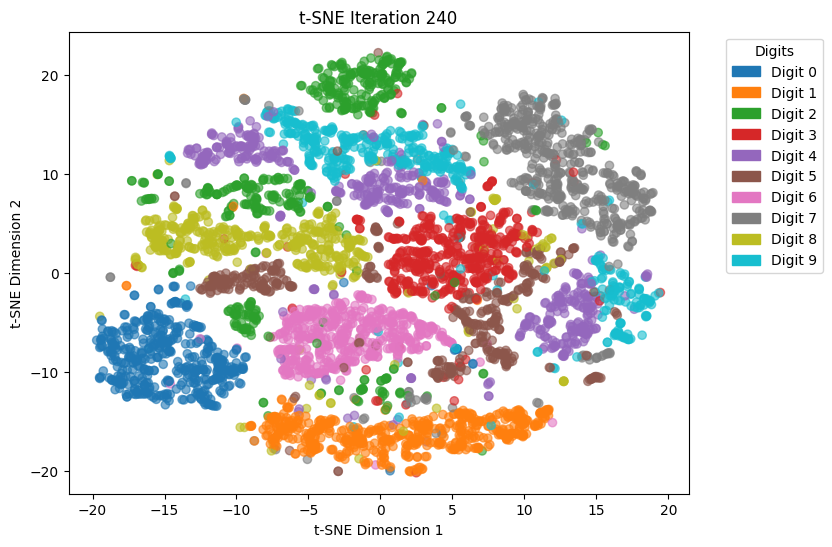

Iteration 260: KL-Divergence = 1.9493


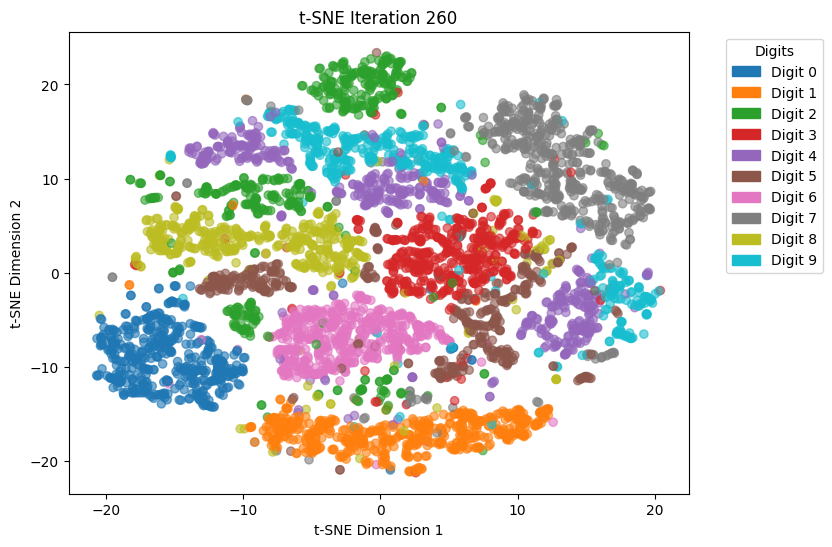

Iteration 280: KL-Divergence = 1.9185


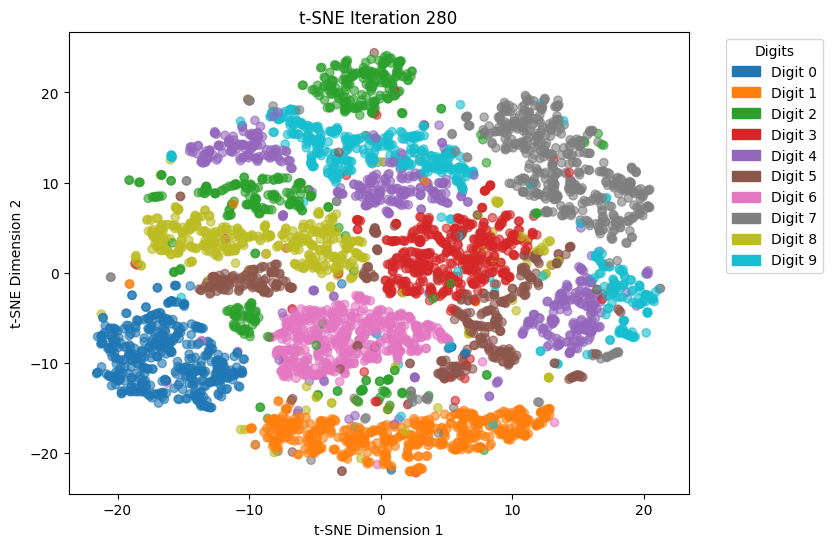

Iteration 300: KL-Divergence = 1.8906


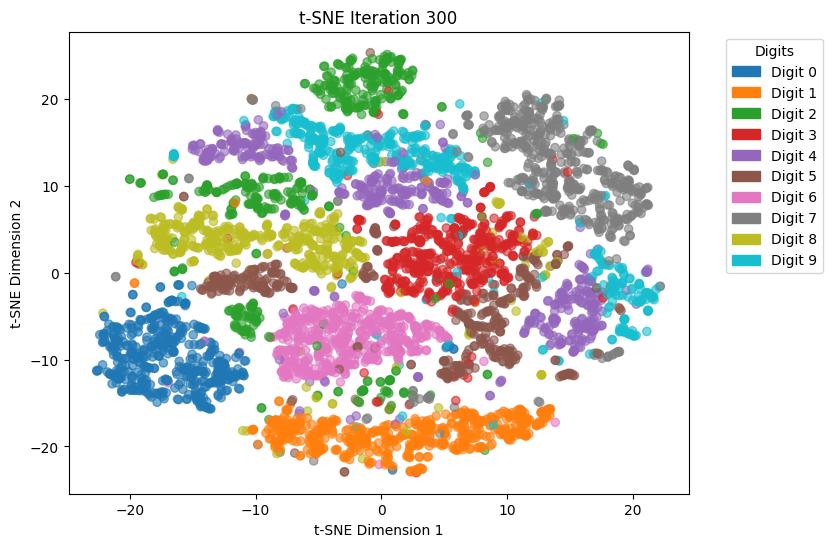

Iteration 320: KL-Divergence = 1.8654


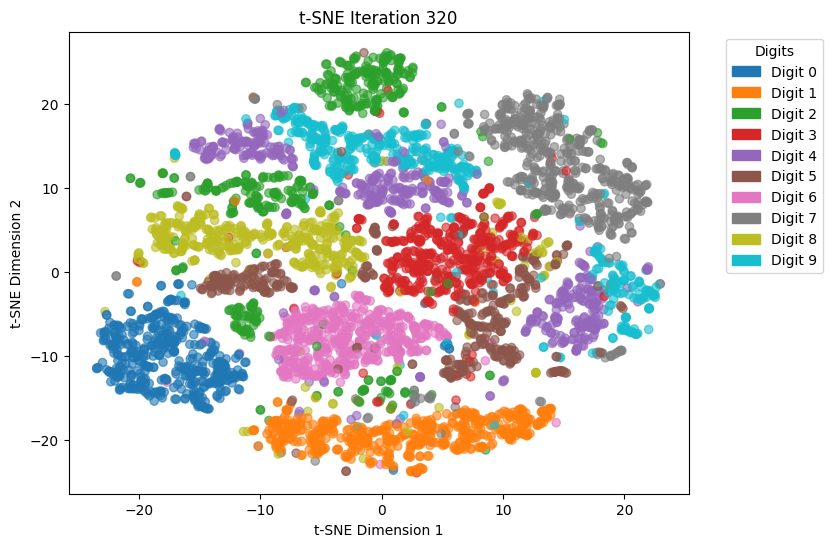

Iteration 340: KL-Divergence = 1.8422


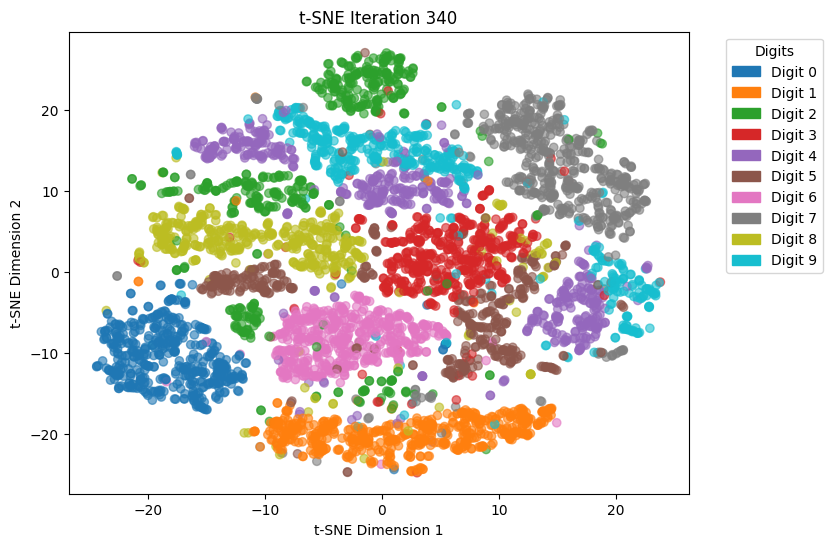

Iteration 360: KL-Divergence = 1.8207


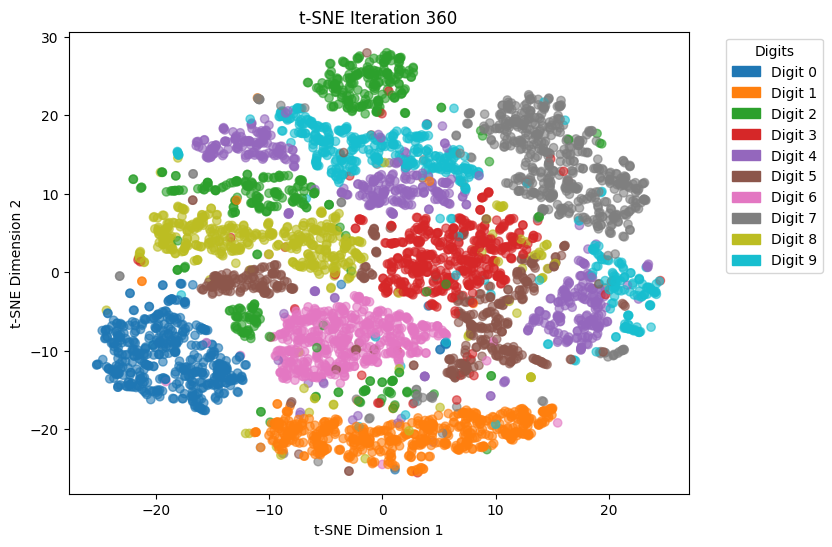

Iteration 380: KL-Divergence = 1.8010


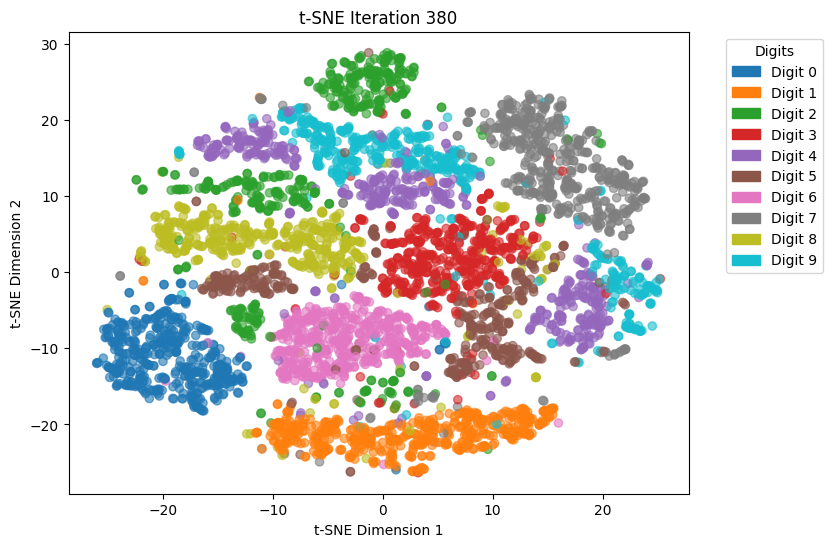

Iteration 400: KL-Divergence = 1.7829


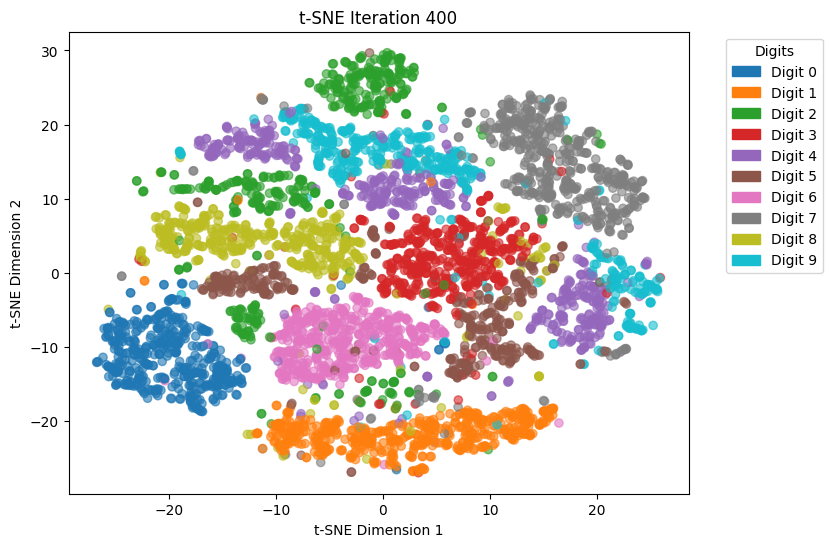

Iteration 420: KL-Divergence = 1.7660


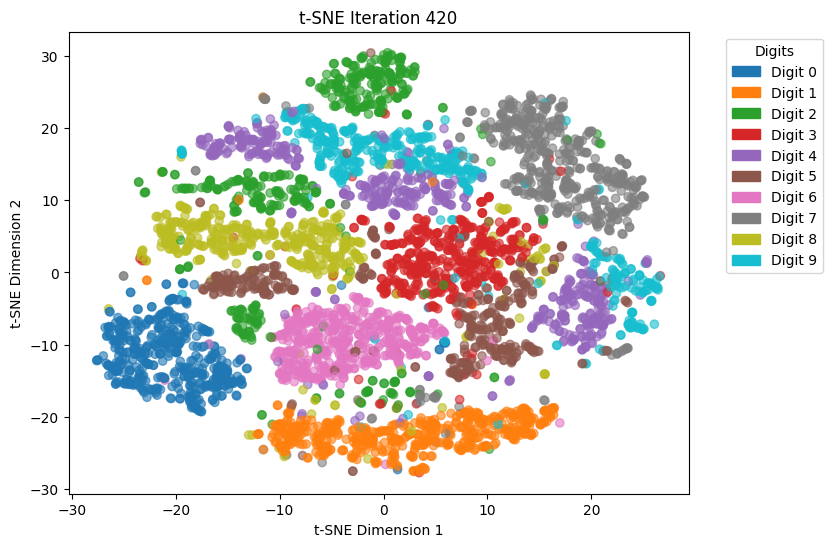

Iteration 440: KL-Divergence = 1.7501


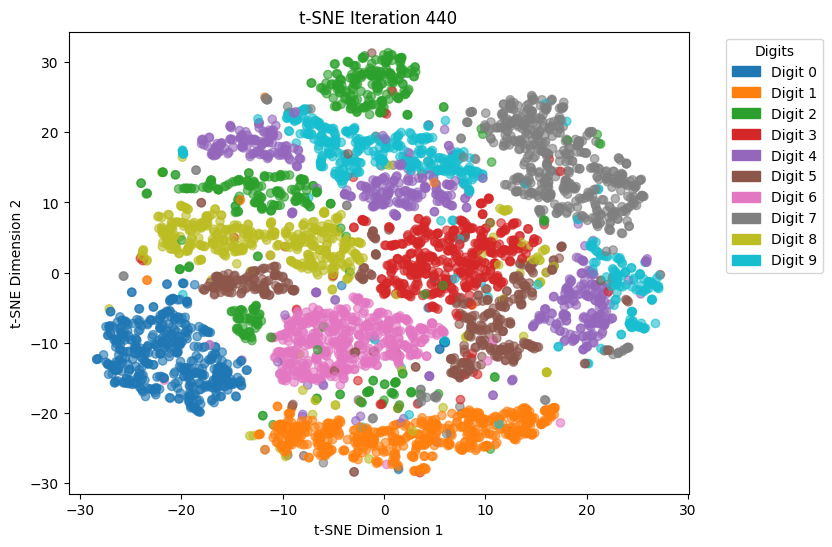

Iteration 460: KL-Divergence = 1.7353


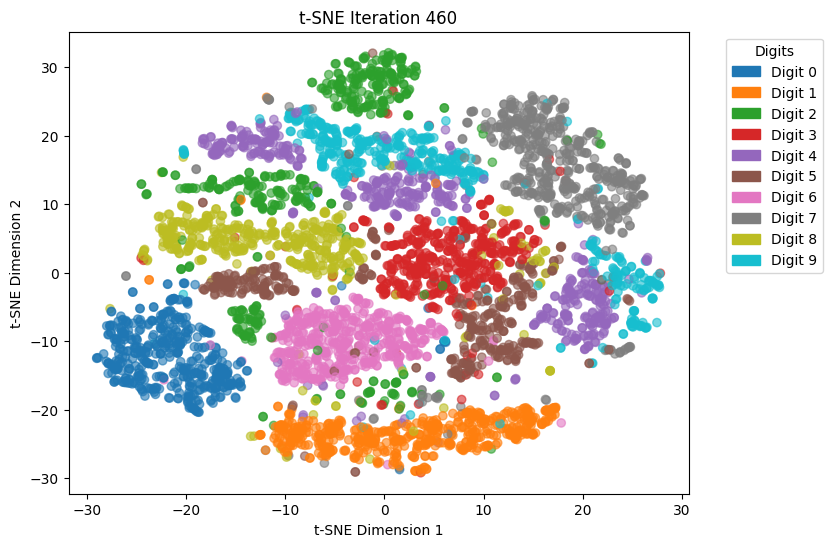

Iteration 480: KL-Divergence = 1.7214


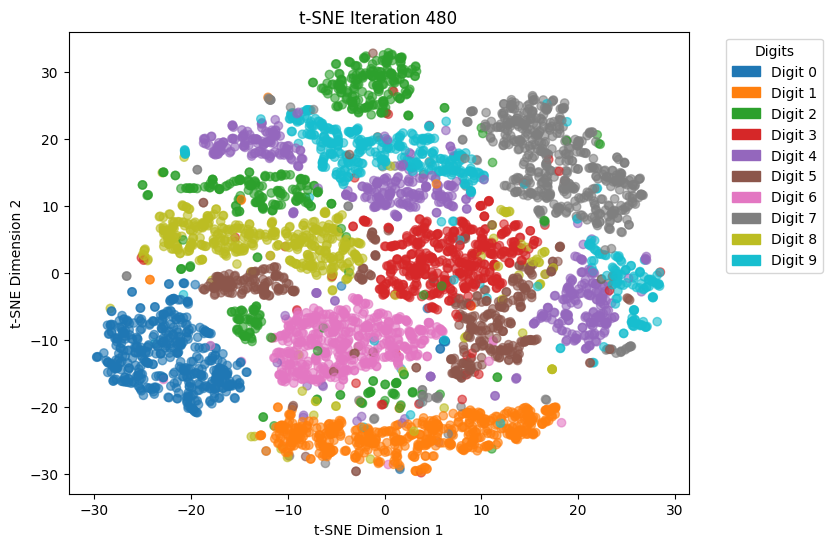

Iteration 500: KL-Divergence = 1.7083


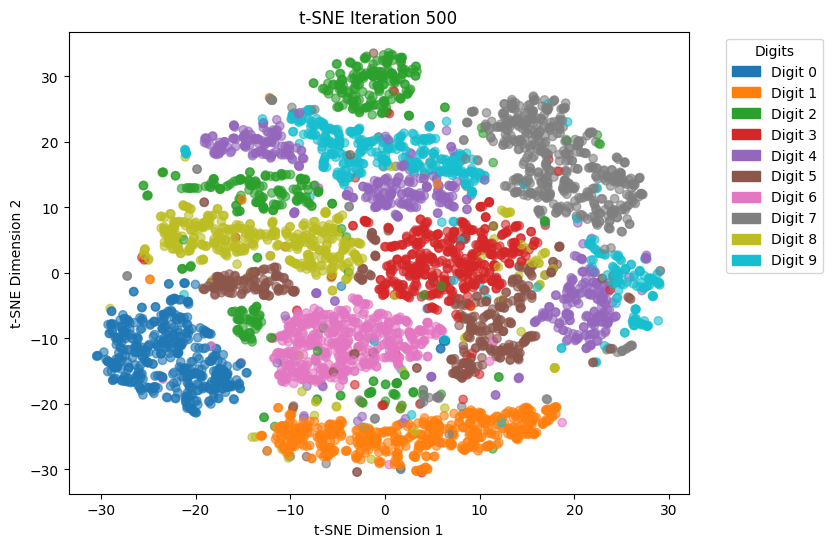

In [7]:
# initialize t-SNE parameters
N, no_dims, max_iter, epsilon, min_gain = P.shape[0], 2, 500, 200, 0.01  # 2D projection, optimization settings
Y = 0.0001 * np.random.randn(N, no_dims)  # initialize positions randomly
Y_incs = np.zeros_like(Y)  # initialize velocity updates
gains = np.ones_like(Y)  # initialize adaptive learning rate gains

# Run t-SNE optimization
for iter in range(1, max_iter + 1):
    sum_Y2 = np.sum(Y**2, axis=1)  # compute squared sum of Y coordinates
    Q_num = 1 / (1 + np.add.outer(sum_Y2, sum_Y2) - 2 * np.dot(Y, Y.T))  # compute q distribution using Student-t distribution
    np.fill_diagonal(Q_num, 0)  # remove self-similarity
    Q = Q_num / np.sum(Q_num)  # normalize Q to make it a valid probability distribution

    PQ_diff = (P - Q) * Q_num  # Compute difference between probability distributions P (high-dim) and Q (low-dim)
    Y_grads = 4 * (np.diag(np.sum(PQ_diff, axis=1)) - PQ_diff) @ Y  # compute gradients for moving points

    # Apply momentum and gradient descent for optimization
    gains = (gains + 0.2) * (np.sign(Y_grads) != np.sign(Y_incs)) + (gains * 0.8) * (np.sign(Y_grads) == np.sign(Y_incs))  # adjust learning rate based on gradient changes
    gains[gains < min_gain] = min_gain  # prevent step sizes from becoming too small
    Y_incs = -epsilon * (gains * Y_grads)  # pdate step for Y positions
    Y += Y_incs  # apply updates
    Y -= np.mean(Y, axis=0)  # re-center Y to maintain stability

    #plots every 20 iterations
    if iter % 20 == 0:
        cost = np.sum(P * np.log((P + 1e-10) / (Q + 1e-10)))  # compute KL-Divergence (loss function)
        print(f"Iteration {iter}: KL-Divergence = {cost:.4f}")  #loss function value every 20 iterations

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(Y[:, 0], Y[:, 1], c=y_mnist, cmap='tab10', alpha=0.6)
        plt.title(f"t-SNE Iteration {iter}")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")

        # digits legends
        unique_labels = np.unique(y_mnist)
        legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f"Digit {label}") for label in unique_labels]
        plt.legend(handles=legend_patches, title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.show()


t-SNE results are affected by the:

* Perplexity → Controls the balance between local vs. global structure.
Low values create tight clusters while high values (~50-100) capture broader relationships.

* Iterations → More iterations refine the embedding. If too low, clusters may not form properly. Usually, 300-1000 is enough.

* KL-Divergence → Measures how well high-dimensional similarities are preserved in 2D. Lower values mean better embedding. Measure how different is the Q distribution vs the P .Cost function in t-SNE.

* Learning rate (epsilon) → Affects how fast points move. Too high causes instability, too low slows convergence. Typically 100-1000.

* Momentum (gains) → Helps smooth updates and avoid poor convergence.

